In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import cv2
import joblib
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import albumentations as A
import time

In [126]:
X = joblib.load("CV2_60.pkl")
y = joblib.load("label.pkl")

To pass an image to the augmentation pipeline you need to call the transform function created by a call to A.Compose at Step 2. In the image argument to that function, you need to pass an image that you want to augment.

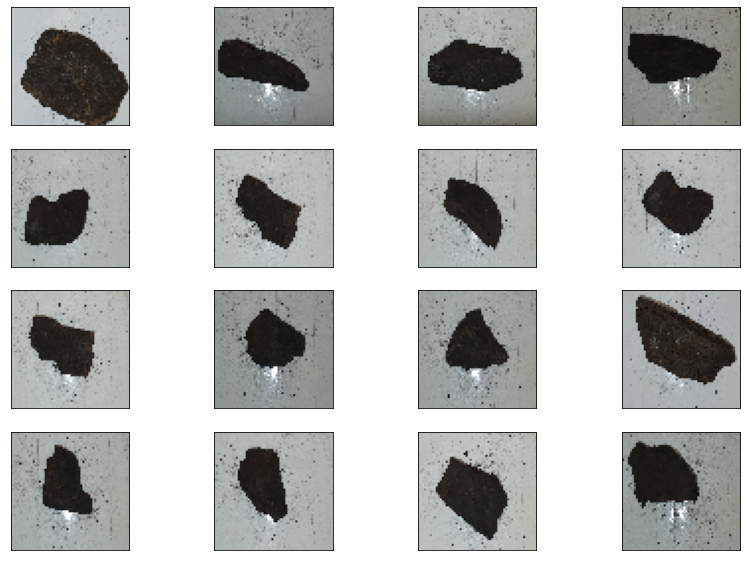

In [127]:
fig = plt.figure(figsize=(14, 10))
for i in range(1, 17):
    ax = plt.subplot(4, 4, i)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.imshow(X[i])

In [97]:
X = np.float32(X)

In [98]:
encoder = OneHotEncoder(sparse=False)
encoder.fit(y.reshape(-1, 1))

OneHotEncoder(sparse=False)

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True)

In [102]:
albumentations_transform = A.Compose([
    A.Resize(32, 32),
#     A.RandomCrop(32, 32),
    A.HorizontalFlip(p=0.5), # Same with transforms.RandomHorizontalFlip()
    A.VerticalFlip(p=0.5),
    A.RandomBrightness(p=0.5, limit=(-0.25, 0.25))
])

C:\Users\hjhhi\anaconda3\envs\python3.9.0\lib\site-packages\albumentations\augmentations\transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


In [103]:
img_list = []
label_list = []
# img_list = np.append(img_list, X)
for _ in range(5):
    for i in range(len(X_train)):
        img_list.append(albumentations_transform(image=X_train[i])["image"])
        label_list.append(y_train[i])

In [104]:
img_list = np.float32(img_list)
img_list = img_list.reshape(-1, 32, 32, 3)
label_list = np.float32(label_list)

In [105]:
X_train = img_list
y_train = label_list

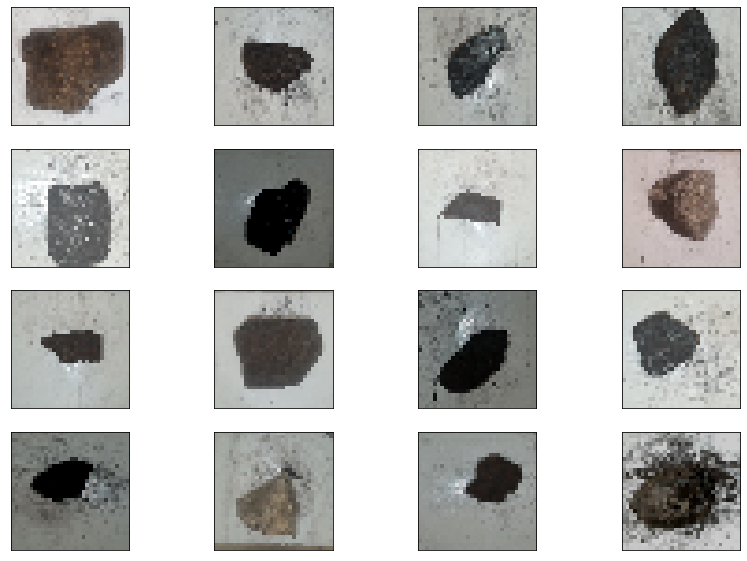

In [106]:
y_train = y_train.reshape(-1, 1)
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test.reshape(-1, 1))

In [107]:
test_trainsform = A.Compose([
A.Resize(32, 32)
])

In [108]:
img_list=[]
for i in range(len(X_test)):
    img_list.append(test_trainsform(image=X_test[i])["image"])
img_list = np.float32(img_list)
X_test = img_list

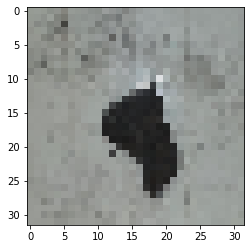

In [109]:
plt.imshow(X_test[1])

# Model

In [110]:
es = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10, mode="max")

In [111]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=3, min_lr=0.00001, verbose=1)

In [112]:
dr_ratio=0.0

Input = keras.layers.Input(shape=X_train[0].shape)

x = keras.layers.Conv2D(16, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(Input)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(2)(x)

# x = keras.layers.Dropout(dr_ratio)(x)

shortcut =x
x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Conv2D(32, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
shortcut = keras.layers.Conv2D(32, kernel_size=5, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
x = keras.layers.Add()([x, shortcut])
x   = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(2)(x)


# x = keras.layers.Dropout(dr_ratio)(x)


shortcut =x
x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
shortcut = keras.layers.Conv2D(64, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
x = keras.layers.Add()([x, shortcut])
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(2)(x)

# x = keras.layers.Dropout(dr_ratio)(x)

shortcut =x
x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
# x = keras.layers.BatchNormalization()(x)
# x = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(x)
shortcut = keras.layers.Conv2D(128, kernel_size=3, activation="relu",kernel_initializer="he_normal", padding="same")(shortcut)
x = keras.layers.Add()([x, shortcut])
x = keras.layers.BatchNormalization()(x)
x = keras.layers.MaxPool2D(2)(x)

# x = keras.layers.Dropout(dr_ratio)(x)


x = keras.layers.GlobalAveragePooling2D()(x)
Output = keras.layers.Dense(4, activation="softmax")(x)

model = keras.models.Model(inputs = Input, outputs = Output)
model.compile(loss="categorical_crossentropy",
optimizer=keras.optimizers.Adam(learning_rate=0.001), metrics=["accuracy"])

history = model.fit(X_train, y_train, validation_data=(X_test, y_test),callbacks=[es, reduce_lr],epochs = 100)
print("Train: ", model.evaluate(X_train, y_train))
print("Valid: ", model.evaluate(X_test, y_test))

Epoch 1/100
854/854 [==============================] - 11s 11ms/step - loss: 0.5192 - accuracy: 0.7875 - val_loss: 0.4346 - val_accuracy: 0.8429
Epoch 2/100
854/854 [==============================] - 9s 11ms/step - loss: 0.2256 - accuracy: 0.9176 - val_loss: 0.2633 - val_accuracy: 0.9115
Epoch 3/100
854/854 [==============================] - 9s 11ms/step - loss: 0.1518 - accuracy: 0.9445 - val_loss: 0.2753 - val_accuracy: 0.9022
Epoch 4/100
854/854 [==============================] - 9s 11ms/step - loss: 0.1178 - accuracy: 0.9566 - val_loss: 0.2950 - val_accuracy: 0.9055
Epoch 5/100
854/854 [==============================] - 9s 11ms/step - loss: 0.0899 - accuracy: 0.9668 - val_loss: 0.3703 - val_accuracy: 0.8709

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 6/100
854/854 [==============================] - 9s 11ms/step - loss: 0.0333 - accuracy: 0.9900 - val_loss: 0.0734 - val_accuracy: 0.9775
Epoch 7/100
854/854 [==============================] 

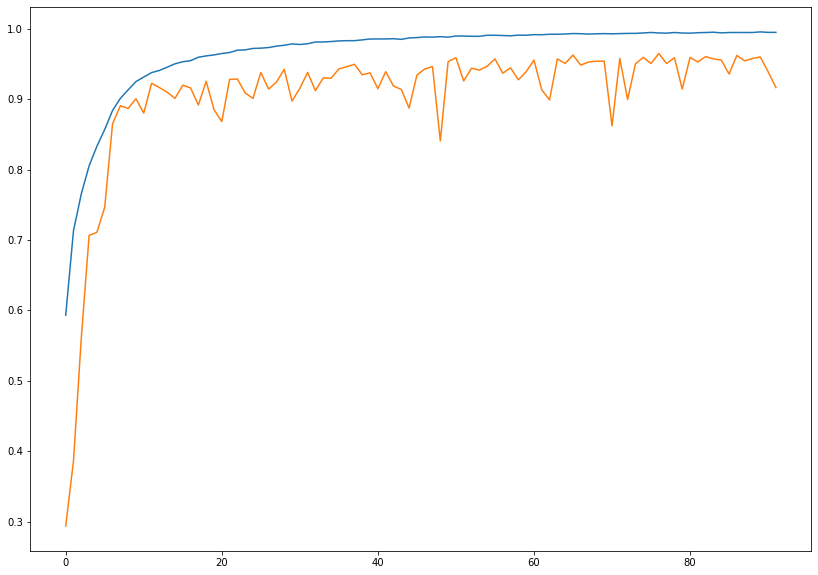

In [18]:
plt.figure(figsize=(14, 10))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])

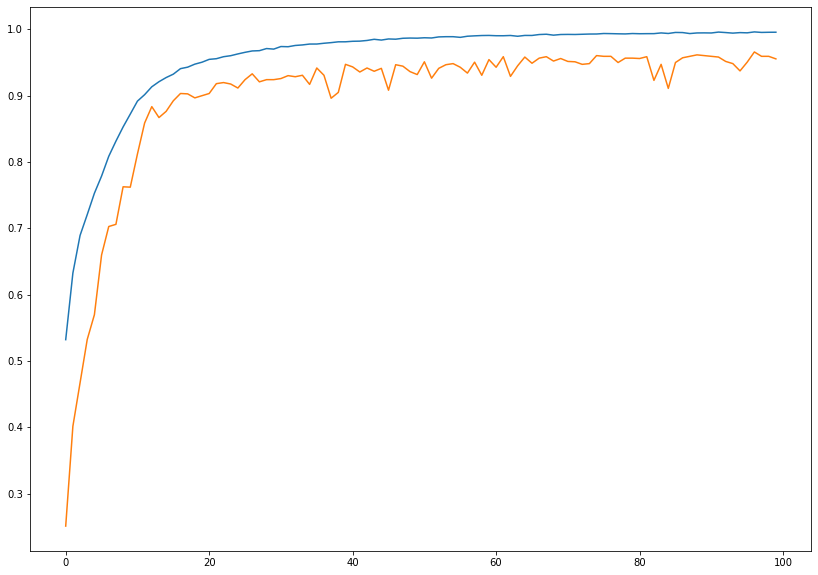

In [31]:
plt.figure(figsize=(14, 10))
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])